In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%run utils/mlflow_query.py
%run utils/loading.py
%run utils/comparison.py
%run utils/percentiles.py

In [3]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"))
mlflow_helper.query_runs(pkl_file=Path("mlflow_run_df.pkl"))

Initialized with 20 MLFlow runs from pkl


MlflowException: API request to http://localhost:5000/api/2.0/mlflow/runs/search failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/search (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fb88bf68ca0>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
def plot_metrics_over_epochs(metric_df, metric_names, 
    column_feature_name='data_tags_model_type', 
    row_feature_name='data_tags_sequence_type',
    hue_feature_name='data_params_ModelConfighidden_embedding_initializer',
    style_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    titles="{row_name}, {col_name}",
):
    for metric_name in metric_names:
        g = sns.relplot(
            data=metric_df, x="epoch", y=metric_name,
            col=column_feature_name, row=row_feature_name, 
            hue=hue_feature_name, style=style_feature_name, 
            units='info_run_id', estimator=None,
            kind="line", facet_kws={'sharey':False},
        )
        g.set_titles(titles)
        g.savefig("epochs_{}.png".format(metric_name))

def plot_best_metric_strip(metric_df, metric_names, feature_names,
    x_feature_name='data_tags_model_type', 
    x_order=['simple', 'gram', 'text', 'text_paper', 'causal'],
    row_feature_name='data_tags_sequence_type',
    hue_feature_name='data_params_ModelConfighidden_embedding_initializer',
    column_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    titles="{row_name}, Trainable: {col_name}",
):
    grouped_df = metric_df.groupby(feature_names, as_index=False).agg({
        metric_name:max for metric_name in metric_names
    })
    for metric_name in metric_names:
        g = sns.catplot(
            data=grouped_df, y=metric_name, 
            x=x_feature_name, order=x_order, row=row_feature_name, 
            hue=hue_feature_name, col=column_feature_name,
            kind="strip", sharey='row',
        )
        g.set_titles(titles).set_axis_labels('', metric_name)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True)

        g.savefig("strip_{}.png".format(metric_name))

def plot_best_metric_bar(metric_df, metric_names,
    x_feature_name='data_tags_model_type', 
    x_order=['simple', 'gram', 'text', 'text_paper', 'causal'],
    row_feature_name='data_tags_sequence_type',
    hue_feature_name='data_params_ModelConfighidden_embedding_initializer',
    col_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    titles="{row_name}, Trainable: {col_name}",
    palette=None,
    dodge=True,
    col_order=None,
):
    for metric_name in metric_names:
        g = sns.catplot(
            data=metric_df, x=x_feature_name, y=metric_name, order=x_order,
            row=row_feature_name, hue=hue_feature_name, col=col_feature_name, col_order=col_order,
            kind="box", sharey='row', palette=palette, dodge=dodge,
        )
        g.set_titles(titles).set_axis_labels('', metric_name)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True)
        g.savefig("bar_{}.png".format(metric_name))


In [ ]:
df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=False, include_drain_hierarchy=True)
df = mlflow_helper.load_best_metrics_for_ids(set(df["info_run_id"]))
df["data_tags_model_type"] = df["data_tags_model_type"].apply(lambda x: {
    "gram": "hierarchy",
    "gram_logs": "template_hierarchy",
}.get(x, x))

g = sns.catplot(
    data=df[
        df["data_params_ModelConfigbase_hidden_embeddings_trainable"].apply(lambda x: x == "False")
    ], x="data_tags_model_type", y='epoch', 
    order=["simple", "hierarchy", "causal", "text"],
    #col="data_params_ModelConfigbase_hidden_embeddings_trainable",
    #col_order=["False", "True"],
    kind="box", 
    palette='Set2', 
    #color="#19b39c",
    #dodge=False,
).set_axis_labels('', "Epochs until convergence")#.set_titles("Embeddings trainable: {col_name}")
plt.tight_layout()
plt.savefig("huawei_epochs_nontrainable.png", dpi=100)
plt.show()

Querying metrics for runs: 100%|██████████| 4/4 [00:00<00:00, 15.84it/s]


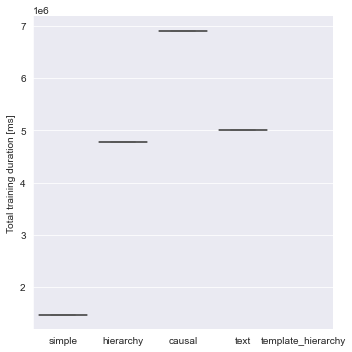

In [7]:
df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=False, include_drain_hierarchy=True)
df = mlflow_helper.load_training_times_for_ids(set(df["info_run_id"]))

df["data_tags_model_type"] = df["data_tags_model_type"].apply(lambda x: {
    "gram": "hierarchy",
    "gram_logs": "template_hierarchy",
}.get(x, x))

g = sns.catplot(
    data=df[
        df["data_params_ModelConfigbase_hidden_embeddings_trainable"].apply(lambda x: x == "True")
    ], x="data_tags_model_type", y='total_duration', 
    order=["simple", "hierarchy", "causal", "text", "template_hierarchy"],
    #col="data_params_ModelConfigbase_hidden_embeddings_trainable",
    #col_order=["False", "True"],
    kind="box", 
    palette='Set2', 
    #color="#19b39c",
    #dodge=False,
).set_axis_labels('', "Total training duration [ms]")#.set_titles("Embeddings trainable: {col_name}")
plt.tight_layout()
plt.savefig("huawei_total_duration_nontrainable.png", dpi=100)
plt.show()

In [8]:
df["avg_per_epoch_conv"] = df["avg_per_epoch"] / (1000)
df[
    df["data_params_ModelConfigbase_hidden_embeddings_trainable"].apply(lambda x: x == "False")
].groupby(by="data_tags_model_type")["avg_per_epoch_conv"].describe()

,count,mean,std,min,25%,50%,75%,max
data_tags_model_type,,,,,,,,
causal,1.0,691.0025,NaN,691.0025,691.0025,691.0025,691.0025,691.0025
hierarchy,1.0,476.8211,NaN,476.8211,476.8211,476.8211,476.8211,476.8211
simple,1.0,147.2588,NaN,147.2588,147.2588,147.2588,147.2588,147.2588
text,1.0,500.8221,NaN,500.8221,500.8221,500.8221,500.8221,500.8221


Querying metrics for runs: 100%|██████████| 4/4 [00:00<00:00, 14.82it/s]
/tmp/ipykernel_456791/4067791009.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["baseline"] = df["data_tags_model_type"] == "simple"


   val_top_10_categorical_accuracy_cp4_history_best  \
0                                               1.0   
1                                               1.0   
2                                               1.0   
3                                               1.0   

   val_top_10_categorical_accuracy_cp4_times_best  \
0                                   1670183731529   
1                                   1670198065142   
2                                   1670189176685   
3                                   1670178457563   

   val_top_20_categorical_accuracy_p3_history_best  \
0                                         0.848179   
1                                         0.814566   
2                                         0.875070   
3                                         0.791597   

   val_top_20_categorical_accuracy_p3_times_best  \
0                                  1670183731534   
1                                  1670198065147   
2                              

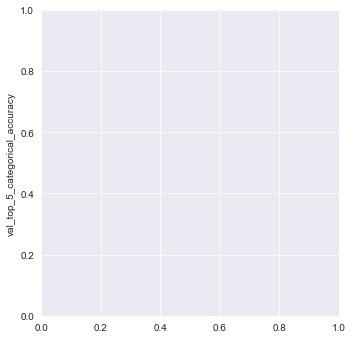

In [11]:
df = mlflow_helper.huawei_run_df(
    include_noise=False, 
    include_refinements=False, 
    risk_prediction=False,
    include_drain_hierarchy=True,
    valid_x_columns=["log_cluster_template", "fine_log_cluster_template", "coarse_log_cluster_template", "attention_log_cluster_template"])

df = mlflow_helper.load_best_metrics_for_ids(set(df["info_run_id"]))
df["data_tags_model_type"] = df["data_tags_model_type"].apply(lambda x: {
    "gram": "hierarchy",
}.get(x, x))
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "log_cluster_template": "fine_log_cluster_template",
}.get(x, x))
df["baseline"] = df["data_tags_model_type"] == "simple"

print(df)

# Box plot from thesis
g = sns.catplot(
    data=df[
        df["data_params_ModelConfigbase_hidden_embeddings_trainable"].apply(lambda x: x == "False")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
    ], x="data_params_SequenceConfigx_sequence_column_name", y='val_top_5_categorical_accuracy_history_best', 
    order=["fine_log_cluster_template", "coarse_log_cluster_template", "attention_log_cluster_template"],
    kind="box", palette='Set2',
    dodge=False,
).set_axis_labels('', "val_top_5_categorical_accuracy")
plt.show()

In [9]:
huawei_df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=False)
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

0    attributes
1    attributes
2    attributes
3    attributes
Name: data_params_SequenceConfigy_sequence_column_name, dtype: object


Querying metrics for runs: 100%|██████████| 4/4 [00:00<00:00, 13.82it/s]


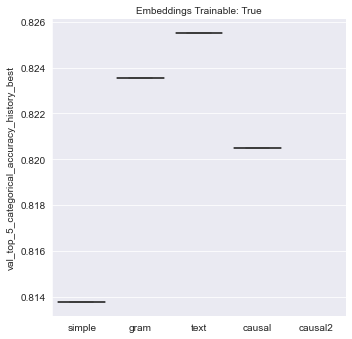

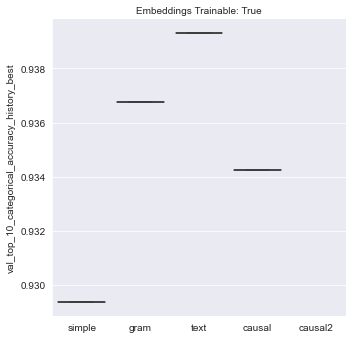

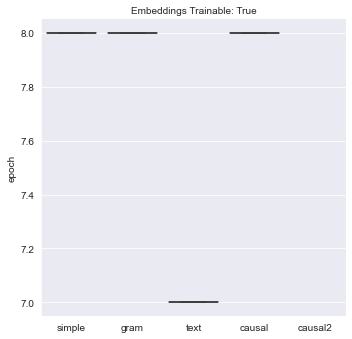

In [10]:
plot_best_metric_bar(huawei_df, ['val_top_5_categorical_accuracy_history_best', 'val_top_10_categorical_accuracy_history_best', 'epoch'], 
    hue_feature_name=None, 
    col_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    row_feature_name=None,
    x_order=["simple", "gram", "text", "causal", "causal2"],
    titles="Embeddings Trainable: {col_name}")
plt.show()

In [11]:
huawei_df = mlflow_helper.huawei_run_df(
    include_noise=False, include_refinements=False, risk_prediction=False, include_drain_hierarchy=True,
    valid_x_columns=["log_cluster_template", "fine_log_cluster_template", "coarse_log_cluster_template", "attention_log_cluster_template_90"])
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

0    attributes
1    attributes
2    attributes
3    attributes
Name: data_params_SequenceConfigy_sequence_column_name, dtype: object


Querying metrics for runs: 100%|██████████| 4/4 [00:00<00:00, 17.91it/s]


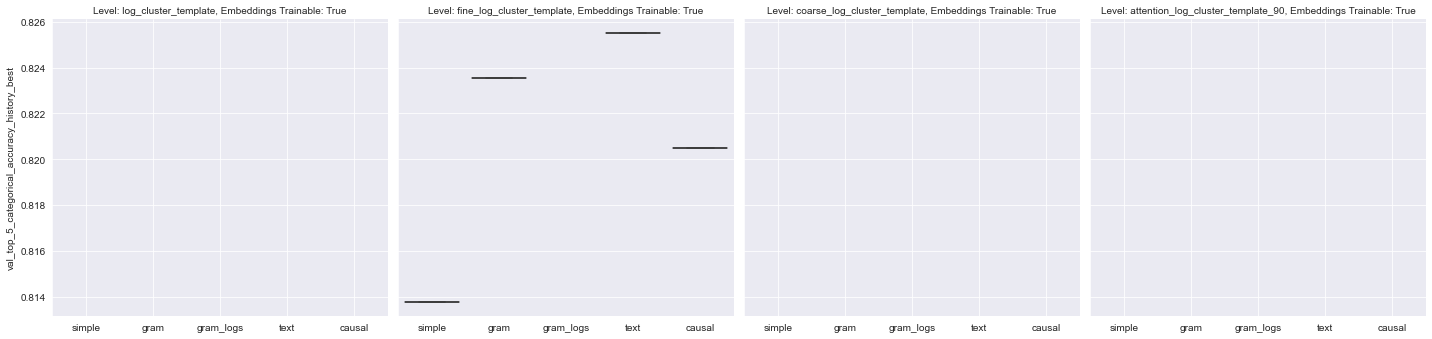

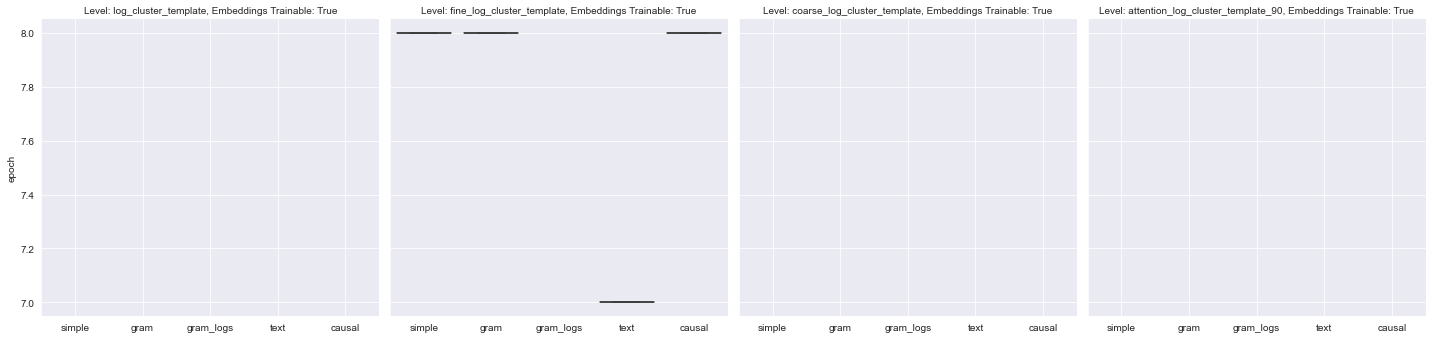

In [12]:
plot_best_metric_bar(huawei_df, ['val_top_5_categorical_accuracy_history_best', 'epoch'], 
    hue_feature_name=None, 
    col_feature_name='data_params_SequenceConfigx_sequence_column_name',
    row_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    col_order=["log_cluster_template", "fine_log_cluster_template", "coarse_log_cluster_template", "attention_log_cluster_template_90"],
    x_order=["simple", "gram", "gram_logs", "text", "causal"],
    titles="Level: {col_name}, Embeddings Trainable: {row_name}")
plt.show()

In [13]:
huawei_df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=True)
huawei_df = mlflow_helper.load_metric_history_for_ids(set(huawei_df["info_run_id"]))

0    attributes
1    attributes
2    attributes
3    attributes
Name: data_params_SequenceConfigy_sequence_column_name, dtype: object


KeyError: 'data_params_SequenceConfigy_sequence_column_name'

In [14]:
plot_metrics_over_epochs(huawei_df, metric_names=['auc_history', 'val_auc_history'])
plt.show()

ValueError: Could not interpret value `auc_history` for parameter `y`

In [15]:
huawei_df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=True)
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

0    attributes
1    attributes
2    attributes
3    attributes
Name: data_params_SequenceConfigy_sequence_column_name, dtype: object


KeyError: 'data_params_SequenceConfigy_sequence_column_name'

In [16]:
prediction_df = pd.read_csv(mlflow_helper.local_mlflow_dir + str(huawei_df["info_run_id"].iloc[0]) + "/artifacts/prediction_output.csv")
prediction_df

,input,output,predictions
0,{0: ['fine_log_cluster_template#get v21 * serv...,"['http_method#get', 'http_status#200.0', 'Host...","{'programname#neutron-server': 0.2219537, 'pyt..."
1,{0: ['fine_log_cluster_template#get v20 ports ...,"['programname#placement-api-access', 'url_clus...","{'programname#neutron-server': 0.16065983, 'py..."
2,{0: ['fine_log_cluster_template#get v21 * serv...,"['programname#neutron-server', 'Hostname#wally...","{'programname#neutron-server': 0.20386536, 'py..."
3,{0: ['fine_log_cluster_template#get v20 ports ...,"['programname#nova-api', 'python_module#nova.o...","{'programname#neutron-server': 0.004968226, 'p..."
4,{0: ['fine_log_cluster_template#get v21 * serv...,"['programname#neutron-server', 'Hostname#wally...","{'programname#neutron-server': 0.22643782, 'py..."
...,...,...,...
16902,{0: ['fine_log_cluster_template#25 nov 2019 20...,"['http_method#get', 'http_status#200.0', 'Host...","{'programname#neutron-server': 0.028805282, 'p..."
16903,{0: ['fine_log_cluster_template#25 nov 2019 20...,"['http_method#get', 'http_status#200.0', 'Host...","{'programname#neutron-server': 0.023701398, 'p..."
16904,{0: ['fine_log_cluster_template#25 nov 2019 20...,"['http_method#get', 'http_status#200.0', 'Host...","{'programname#neutron-server': 0.016520182, 'p..."
16905,{0: ['fine_log_cluster_template#25 nov 2019 * ...,"['http_method#get', 'http_status#200.0', 'Host...","{'programname#neutron-server': 0.010304666, 'p..."


In [17]:
prediction_df['input'].apply(lambda x: 1 if "exception" in x.lower() else 0).sum()

1149

In [18]:
plot_best_metric_bar(huawei_df, ['val_auc_history_best', 'auc_history_best', 'epoch'], 
    hue_feature_name=None, 
    col_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    row_feature_name=None,
    x_order=["simple", "gram", "text", "causal", "causal2"],
    titles="Embeddings Trainable: {col_name}")
plt.show()

ValueError: Could not interpret input 'val_auc_history_best'

# NOISE

In [ ]:
mimic_noise_df = mlflow_helper.mimic_run_df(include_noise=True)
mimic_noise_df = mlflow_helper.load_best_metrics_for_ids(set(mimic_noise_df["info_run_id"]))
mimic_noise_df['data_tags_noise_type'] = mimic_noise_df['data_tags_noise_type'].fillna('').astype(str).apply(lambda x: x + '_threshold0.0' if len(str(x)) <= len('added0.0_removed0.1') and len(x) > 0 else x)
mimic_noise_df['data_tags_noise_type'] = mimic_noise_df['data_tags_noise_type'].apply(lambda x: 'no_noise' if len(x) == 0  or x == 'nan' else x)

In [ ]:
mimic_noise_df = mimic_noise_df[mimic_noise_df['data_tags_model_type'].apply(lambda x: x in ['hierarchy', 'gram', 'causal', 'text'])].copy().reset_index(drop=True)
mimic_noise_df = mimic_noise_df[mimic_noise_df['data_tags_noise_type'].str.endswith('_threshold0.0') | mimic_noise_df['data_tags_noise_type'].str.endswith('no_noise')].copy().reset_index(drop=True)
mimic_noise_df['noise'] = mimic_noise_df['data_tags_noise_type'].apply(
    lambda x: float(x[len('added'):len('added0.0')]) - float(x[len('added0.0_removed'):len('added0.0_removed0.0')]) if not (x == 'no_noise') else 0.0
)
mimic_noise_df['Knowledge Graph'] = mimic_noise_df['noise'].apply(lambda x: 'Original' if x == 0.0 else 'Noisy')
mimic_noise_df["Domain Knowledge"] = mimic_noise_df["data_tags_model_type"].apply(lambda x: {
    "gram": "hierarchy",
}.get(x, x))

g = sns.catplot(
    data=mimic_noise_df[
        mimic_noise_df["data_params_ModelConfigbase_hidden_embeddings_trainable"] == "False"
    ], x="noise", y='val_top_20_categorical_accuracy_history_best', 
    col="Domain Knowledge",
    col_order=["hierarchy", "causal", "text"],
    kind="box", palette='Set2',
    hue="Knowledge Graph", dodge=False,
    hue_order=["Noisy", "Original"],
).set_axis_labels('Degree of Noise', "val_top_20_categorical_accuracy").set_titles("Domain Knowledge: {col_name}")

#plt.tight_layout()
plt.savefig("noise.png", dpi=100, bbox_inches="tight")
plt.show()